# Taller 3

In [10]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import sympy as sym 
import random as rand
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import qexpy as q
from scipy import integrate
from scipy.integrate import odeint

### 1.

##### a)

#### b)

Partiendo del sistema autónome lineal:

$$
x'=2x-y\\
y'=x+2y
$$

y que la matriz de estabilidad está dada por:

$$
\begin{equation}
\begin{pmatrix}
\frac{\partial f(q_0,p_0)}{\partial q}&\frac{\partial f(q_0,p_0)}{\partial p}\\
\frac{\partial g(q_0,p_0)}{\partial q}&\frac{\partial g(q_0,p_0)}{\partial p}
\end{pmatrix}
\end{equation}
$$

Entonces, teniendo en cuenta que para este sistema la función $f$ es $2x-y$ y $g$ es $x+2y$, la matriz de estabilidad para este sistema estaría dada por:

$$
\begin{equation}
\begin{pmatrix}
2&-1\\
1&2
\end{pmatrix}
\end{equation}
$$



#### c)

In [2]:
M=np.array([[2,-1],[1,2]])


In [5]:
np.linalg.eig(M)

(array([2.+1.j, 2.-1.j]),
 array([[0.70710678+0.j        , 0.70710678-0.j        ],
        [0.        -0.70710678j, 0.        +0.70710678j]]))

#### d)

In [7]:
def System(r,t):
    x=r[0]
    y=r[1]
    
    dx=2*x-y
    dy=x+2*y
    
    return [dx,dy]

In [15]:
def IntegratorAdams(f,r0,t):
    
    
    x = np.zeros_like(t)
    vx = np.zeros_like(t)
    
    x[0] = r0[0]
    vx[0] = r0[1]
    
    K11 = np.zeros(2)
    K12 = np.zeros(2)
    
    present = np.array([x[0],vx[0]])
    K11 = f(present,t[0])
    
    # Euler
    x[1] = x[0] + h*K11[0]
    vx[1] = vx[0] + h*K11[1]
    
    xc = x.copy()
    vxc = vx.copy()
    
    for i in range(2,len(t)):
        
        present = np.array([x[i-1],vx[i-1]])
        past = np.array([x[i-2],vx[i-2]])
        
        K11 = f(present,t[i-1])
        K12 = f(past,t[i-2])
        
        x[i] = x[i-1] + 0.5*h*(3*K11[0]-K12[0])
        vx[i] = vx[i-1] + 0.5*h*(3*K11[1]-K12[1])
        
        xc[i] = x[i]
        vxc[i] = vx[i]
        
        # Futuro
        futuro = np.array([x[i],vx[i]])
        K13 = f(futuro,t[i])
        
        xc[i] = xc[i-1] + h*(5*K13[0]+8*K11[0]-K12[0])/12
        vxc[i] = vxc[i-1] + h*(5*K13[1]+8*K11[1]-K12[1])/12
    
    return x,vx,xc,vxc

In [47]:
t=np.linspace(0,5,1000)
h = t[1] - t[0]
r0=[0.-h,0.-h]
sol=odeint(System,r0,t)
sol2=IntegratorAdams(System,r0,t)


<IPython.core.display.Javascript object>


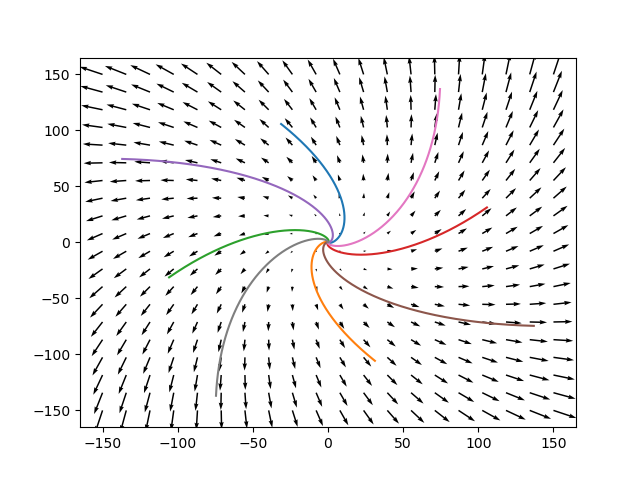

In [45]:
fig=plt.figure()
ax=fig.add_subplot()

rs=[(0-h,0),(0+h,0),(0,0-h),(0,0+h),(0-h,0-h),(0+h,0+h),(0-h,0+h),(0+h,0-h)]


for i in rs:
    sols=IntegratorAdams(System,i,t)
    ax.plot(sols[0],sols[1])
    
xlimit=np.linspace(-150,150,20)
ylimit=np.linspace(-150,150,20)

r0s=[x,y]
sysx=System(r0s,t)[0]
sysy=System(r0s,t)[1]
x,y=np.meshgrid(xlimit,ylimit)
ax.quiver(x,y,sysx,sysy)

    

El punto crítico es en (0,0)

### 2.

In [137]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Euler
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial 
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(3):
            
            if self.r[i] + self.radius > 10 and self.v[i] > 0.:
                self.v[i] = -self.v[i]
            elif self.r[i] - self.radius < -10 and self.v[i] < 0.:
                self.v[i] = -self.v[i]


In [144]:
def GetFiftyParticles(N,t):
    i=0
    FiftyParticles=[]
    
    #PASAR A 50
    
    while i<50:
        r=np.array([rand.uniform(-10.,10.),rand.uniform(-10.,10.),rand.uniform(-10.,10.)])
        v=np.array([rand.uniform(-5.,5.),rand.uniform(-5.,5.),rand.uniform(-5.,5.)])
        a=np.array([0.,0.,0.])
        particle=Particle(r,v,a,t,m=1,radius=0.1,Id=i)
        
        i+=1
        FiftyParticles.append(particle)
        
    return FiftyParticles

In [145]:
#PASO
dt = 0.01
tmax = 20
t = np.arange(0,tmax,dt)
Particles = GetFiftyParticles(1,t)

In [146]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [147]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 2000/2000 [00:29<00:00, 67.72 Steps/s]


In [148]:
scale = 50
t1 = t[::scale]

<IPython.core.display.Javascript object>


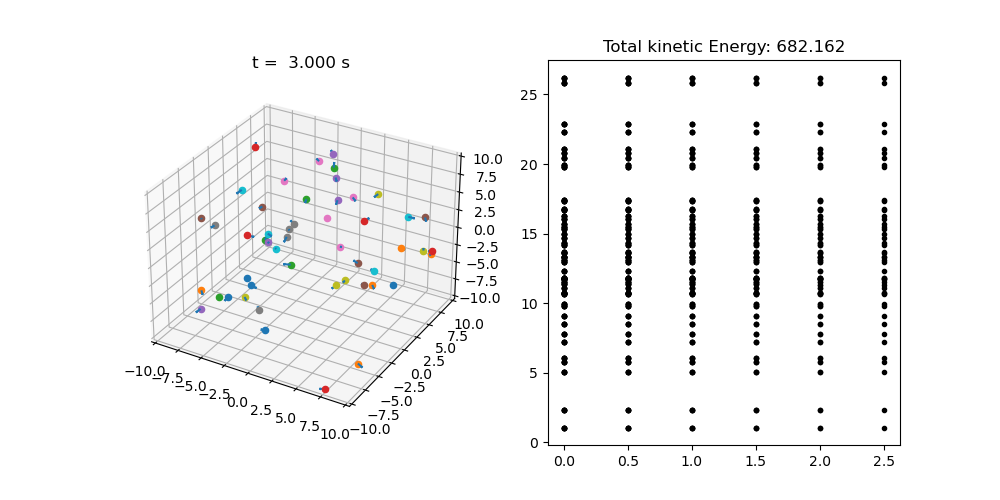

In [149]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121,projection='3d')
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_zlim(-10,10)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        z = p.GetPosition(scale)[i,2]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        vz = p.GetVelocity(scale)[i,2]
        
        circle = plt.Circle( (x,y,z), p.radius, color='r', fill=False )
        ax.quiver(x,y,z,vx,vy,vz,length=0.1)
        ax.scatter(x,y,z)
         
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)


### 3.

#### a)

#### b)

#### c)

#### d)

#### e)

#### f)

#### g)

### 4. Viaje a la Luna

#### a)

#### b)

#### c)

#### d)

#### e)

#### f)

#### g)